# Video processing

This notebook is used to process videos and show some images with overlay of the segmentation

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import tensorflow        as tf


from skimage.transform import resize
from PIL               import Image

from moviepy.editor import VideoFileClip

%matplotlib inline

/home/ongxa/.virtualenvs/cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Constants

TRAIN_IMAGE_FOLDER       = './Data/Train/CameraRGB'
TRAIN_CAMSEG_FOLDER      = './Data/Train/CameraSeg'
TRAIN_LABEL_FOLDER       = './Data/Train/Label'

VAL_IMAGE_FOLDER       = './Data/Validation/CameraRGB'
VAL_CAMSEG_FOLDER      = './Data/Validation/CameraSeg'
VAL_LABEL_FOLDER       = './Data/Validation/Label'


In [3]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name='')
    return graph

# load the graph
graph = load_graph('./keras_opt_model.pb')

# We access the input and output nodes 
x0 = graph.get_tensor_by_name('img_i_1:0')
x1 = graph.get_tensor_by_name('img_f_1:0')
y = graph.get_tensor_by_name('class_1/Sigmoid:0')

sess = tf.Session(graph=graph)

In [4]:
# Crop the sky and the hood
CROP_REGION = (0,200,800,525)

# Define the image size to be near the aspect ratio
# And as well a multiple of 32, as the network scale down to 1/32
NET_INPUT_IMG_SIZE    = (224,544)

# New crop region to focus on small cars
# This is a centered region of size NET_INPUT_IMG_SIZE
CROP_REGION_FOCUS = (128,188,672,412)


def process_image(img):
    # Define our binary results
    binary_road = np.zeros(img.shape[:2]).astype('uint8')
    binary_car  = np.zeros(img.shape[:2]).astype('uint8')
    
    
    # Need to resize the frame
    img_f = img[CROP_REGION_FOCUS[1]:CROP_REGION_FOCUS[3],CROP_REGION_FOCUS[0]:CROP_REGION_FOCUS[2]] / 255.
    img_i = resize(img[CROP_REGION[1]:CROP_REGION[3]],(NET_INPUT_IMG_SIZE[0], NET_INPUT_IMG_SIZE[1]),
                               mode='reflect')

    # Get the prediction of this image
    pred = sess.run(y, feed_dict={ x0: [img_i], x1 : [img_f] })

    # Resize to our cropped region
    pred_r = resize(pred[0], (CROP_REGION[3]-CROP_REGION[1],CROP_REGION[2]-CROP_REGION[0]), mode='reflect')

    # Assign our prediction to our cropped region, anything outside is zero
    binary_road[CROP_REGION[1]:CROP_REGION[3]] = np.where(pred_r[:,:,0]>0.9,1,0).astype('uint8')
    binary_car[CROP_REGION[1]:CROP_REGION[3]]  = np.where(pred_r[:,:,1]>0.4,1,0).astype('uint8')

    # Apply the mask to the image
    mask_road = np.where(binary_road==1)
    mask_car  = np.where(binary_car==1)
    
    img[:,:,2][mask_road] = img[:,:,1][mask_road]*(1-0.8) + binary_road[mask_road]*255*0.8
    img[:,:,1][mask_car]  = img[:,:,0][mask_car] *(1-0.5) + binary_car[mask_car]  *255*0.5
    
    
    return img

## Examples with segmentation

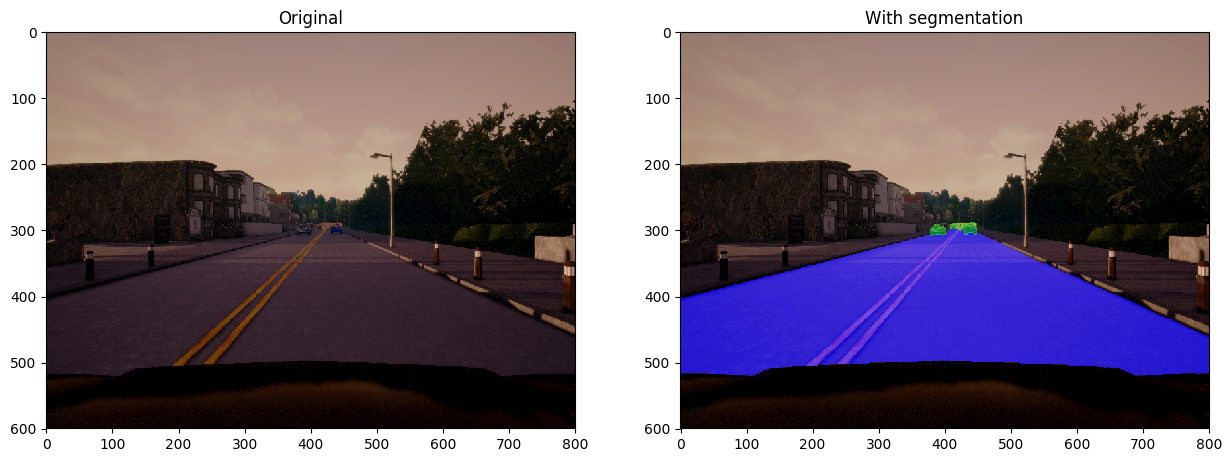

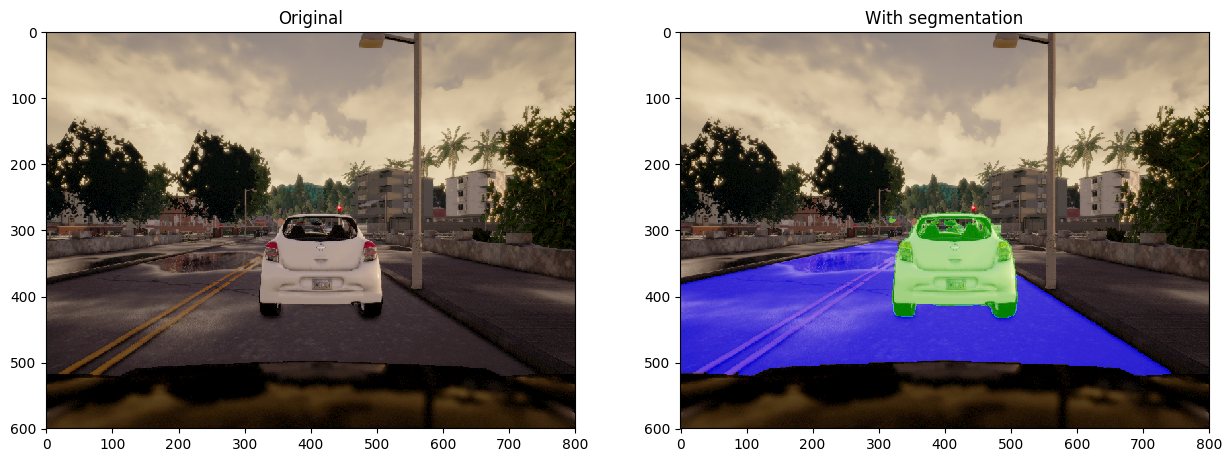

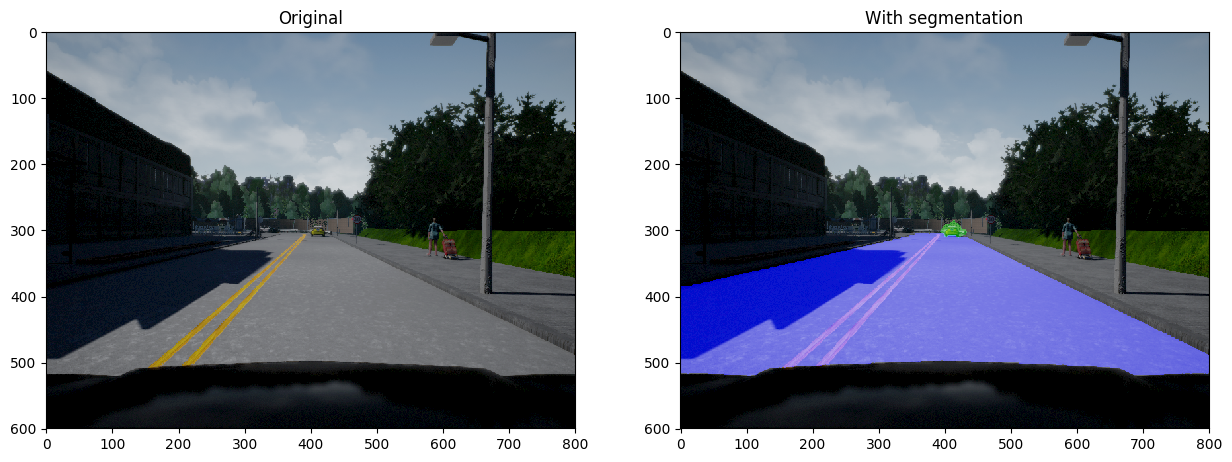

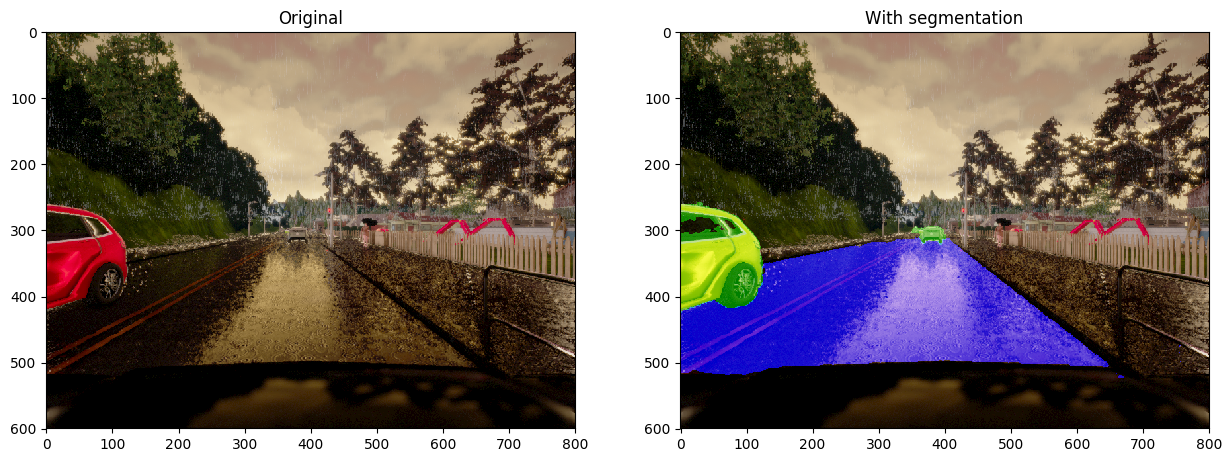

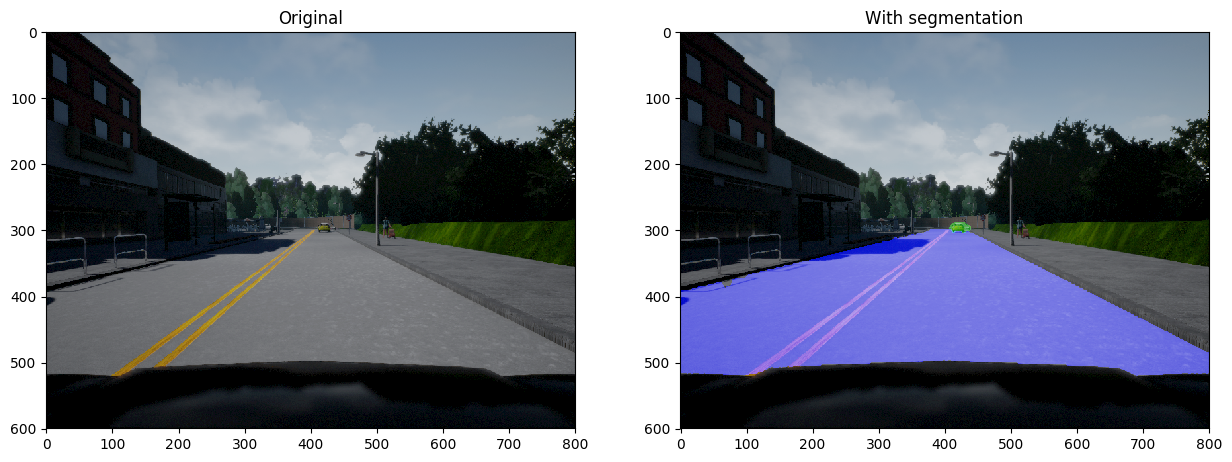

In [6]:
ix = 0
for img_id in np.random.choice(range(1000), size=5):
    img   = np.array(Image.open(f'{VAL_IMAGE_FOLDER}/{img_id}.png'))

    img_u = process_image(img.copy())
    
    plt.figure(dpi=100, figsize=(15,15))
    plt.subplot(121)
    plt.title('Original')
    plt.imshow(img)
    plt.subplot(122)
    plt.title('With segmentation')
    plt.imshow(img_u)
    plt.show()
    

In [ ]:
video_filename_prefix = 'mixed_test_video'

clip1 = VideoFileClip('./Videos/{}.mp4'.format(video_filename_prefix), audio=False)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile('./Videos/{}_out.mp4', audio=False)

In [ ]:
# Real worl example
#video_filename_prefix = 'curvy_mountain_challenge'
#video_filename_prefix = 'gray_day_wide_FOV'
video_filename_prefix = 'city_streets'

# Just take the 1st minute and resize
clip1 = VideoFileClip('./Videos/{}.mp4'.format(video_filename_prefix), audio=False).subclip(0,60).resize((800,600))
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile('./Videos/{}_out.mp4'.format(video_filename_prefix), audio=False)